# 🖼️ Part III: Conformal Object Detection

We are working with an object detection model that is already in production and accessible only through API requests (i.e., we don't have direct access to the model instance). Let's create an instance of the API, which we will use later to query the model and obtain bounding box predictions for images:

Let's do conformal object detection on COCO.

<div align=center>
<img src="assets/object_detection_demo.svg" width="800"> </img>
</div>

**Links**
- [<img src="https://github.githubassets.com/images/icons/emoji/octocat.png" width=20> Github](https://github.com/deel-ai/puncc)
- [📘 Documentation](https://deel-ai.github.io/puncc/index.html)

### ⚙️ Setup  <a class="anchor" id="cr-setup"></a>

🐾 For this tutorial, we need to install puncc along with transformers library

In [1]:
!pip install puncc transformers==4.44.2

  Using cached transformers-4.44.2-py3-none-any.whl.metadata (43 kB)
Using cached transformers-4.44.2-py3-none-any.whl (9.5 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.41.0
    Uninstalling transformers-4.41.0:
      Successfully uninstalled transformers-4.41.0

[notice] A new release of pip is available: 23.3.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


We import the general-purpose modules that will be used throughout the tutorial:

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
import os
import warnings
import seaborn as sns

sns.set_theme()

warnings.filterwarnings("ignore")

if "google.colab" in sys.modules:
    os.system(
        "wget https://raw.githubusercontent.com/deel-ai/uq-masterclass/refs/heads/main/tutorial_notebooks/utils.py"
    )
    os.system("mkdir assets/")
else:
    print("Not running in Google Colab")


from utils import CocoDataset, ObjectDetectionAPI

2024-11-12 14:29:42.175804: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 14:29:42.175834: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 14:29:42.175862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 14:29:42.182654: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 14:29:44.069925: W tensorflow/compiler/

### 💾 Dataset <a class="anchor" id="cr-data"></a>

COCO (Common Objects in Context) dataset is a widely used benchmark dataset for object detection. It consists of a large collection of images with detailed annotations, including bounding boxes and object classes. The dataset covers a wide range of object categories and provides a diverse set of images captured in various contexts.

The annotations in the dataset provide ground truth information that can be used to train and evaluate the performance of object detection models. In our scenario, we assume the object detection model is already in production and accessible through an API, so there is no need for training samples. Instead, we will focus on data for **calibration**, as part of the conformal prediction procedure, and a **test** dataset to evaluate the performance of uncertainty quantification in object detection.

We will use a portion of the 2017 validation data for calibration and the remainder for testing. The annotations configuration file, which provides the image URLs and associated labels, can be downloaded from the [COCO website](https://cocodataset.org/#download). For simplicity, we have included this file as part of the tutorial.

In [3]:
# Load the validation dataset
dataset = CocoDataset(shuffle=True)
# Split the dataset into calibration and test subsets
calib_dataset, test_dataset = dataset.split(test_size=0.95)

Calibration dataset size: 247
Test dataset size: 4705


### 🔮 Prediction Models <a class="anchor" id="cr-pm"></a>


We are working with an object detection model that is already in production and accessible only through API requests (i.e., we don't have direct access to the model instance). Let's create an instance of the API, which we will use later to query the model and obtain bounding box predictions for images:

In [4]:
# create an instance of the API
object_detection_api = ObjectDetectionAPI(min_iou=0.6)

### ⚙️ Conformal Prediction <a class="anchor" id="ob-cp"></a>

The figure below summarizes our scenario: 

<div align=center>
<img src="assets/object_detection_demo.svg" width="800"> </img>
</div>

From our perspective, the predictions served through the API are generated by an unknown model that is not directly accessible. However, we can still apply conformal prediction techniques to it!

Although we don't have a model object to wrap, we can create a proxy using *puncc* using [`IdPredictor`](https://deel-ai.github.io/puncc/prediction.html#prediction.IdPredictor).

In [5]:
from deel.puncc.api.prediction import IdPredictor

# Create the proxy of object detection model
api_model = IdPredictor()

Now we are ready to perform conformal object detection on COCO. The following code snippet is the template we will follow to implement our conformal object detector !

<div align=center>
<img src="assets/workflow_object_detection.svg" width="800"> </img>
</div>

#### 1. Instantiation

We define an instance of the conformal predictor `SplitBoxWise`. Make sure the argument `train` is set to False, as the model is already trained:

In [6]:
from deel.puncc.object_detection import SplitBoxWise

# Instantiate conformal predictor
api_cp = SplitBoxWise(api_model, train=False)

#### 2. Calibration

Retrieve predictions and labels for 150 instances (or more up to 247, though this may slow down the process) of the calibration data using the model's API. This data will be used to calibrate the model.

In [ ]:
# get calibration data through API
y_calib_api, y_calib_coco, calib_images, calib_labels = object_detection_api.query(
    calib_dataset, n_instances=20
)

  8%|▊         | 19/247 [00:28<05:36,  1.48s/it]


Now we can fit our conformal predictor. The non-conformity scores are computed and stored within the conformal prediction object.

In [8]:
# Fit conformal predictor
api_cp.fit(X_calib=y_calib_api, y_calib=y_calib_coco)

#### 3. Conformal Inference

We first choose an new image and send a request to the API to get the point prediction:

In [9]:
# Select an image from the test dataset
image, bboxes, classes = test_dataset[8]

# Predict on the image
y_new_api = object_detection_api.predict_from_image(image)

Finally, we can infer the uncertainty of the model on an example using our conformal predictor. We have to set a level of risk $\alpha$ that is acceptable for us.

In [10]:
# Choose the coverage target 1-alpha
alpha = 0.3

# Inference + UQ
y_pred_new, box_inner, box_outer = api_cp.predict(y_new_api, alpha=alpha)

Let's visualize the results:

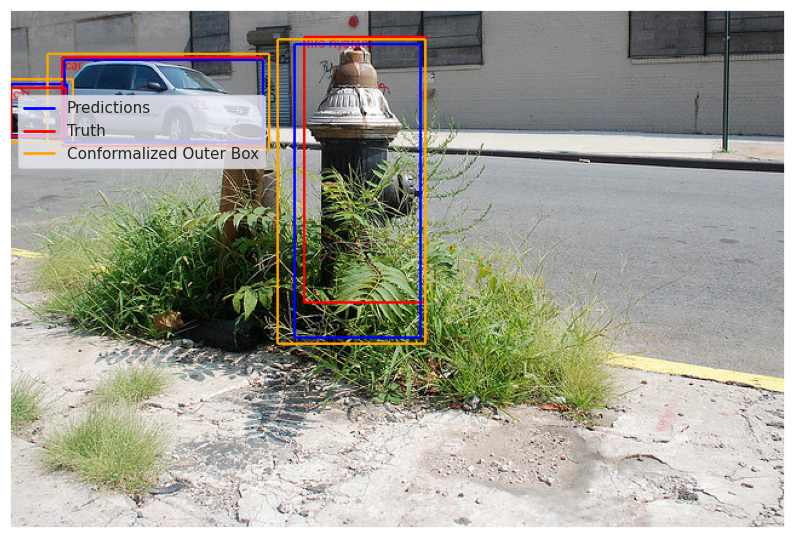

In [11]:
from deel.puncc.plotting import draw_bounding_box

image_with_bbox = image.copy()

for i in range(min(len(bboxes), len(y_pred_new))):
    try:
        image_with_bbox = draw_bounding_box(
            image=image_with_bbox,
            box=y_pred_new[i],
            legend="Predictions",
            color="blue",
        )
        image_with_bbox = draw_bounding_box(
            image=image_with_bbox,
            box=bboxes[i],
            label=classes[i],
            legend="Truth",
            color="red",
        )
        image_with_bbox = draw_bounding_box(
            image=image_with_bbox,
            box=box_outer[i],
            legend="Conformalized Outer Box",
            color="orange",
        )
    except Exception as e:
        print(f"Warning: Could not display bbox {i}")
        continue

_ = draw_bounding_box(image=image_with_bbox, show=True)